In [5]:
%load_ext autoreload
%autoreload 2 

In [4]:
from __future__ import print_function, absolute_import, division

In [3]:
from GomokuBoard import GomokuBoard
from HeuristicPolicy import HeuristicGomokuPolicy
from Heuristics import Heuristics
from GomokuTools import GomokuTools as gt
from GomokuData import data_from_game
stones=gt.string_to_stones('e10g8g5f5f6e7f7f8e8g9h10d9g10f10h8h9i9g7e9j8h11i12e11e12g11f11f12e13g13h14i10g14j9k8i8k4i7')
heuristics = Heuristics(kappa=3.0)

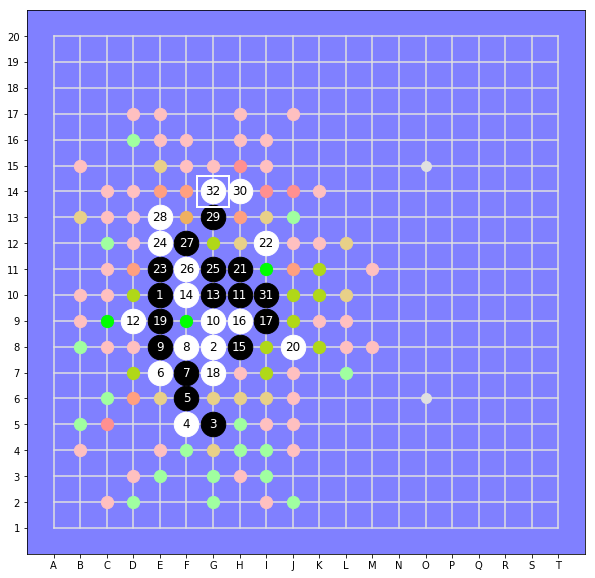

In [70]:
board = GomokuBoard(heuristics=heuristics, N=20, stones=stones, disp_width=10)
board.undo().undo().undo().undo().undo().display('current')

In [71]:
from GomokuData import create_sample, data_from_game, to_matrix12

In [72]:
board = GomokuBoard(heuristics=heuristics, N=20, stones=stones, disp_width=10)
board.undo().undo().undo()
policy = HeuristicGomokuPolicy(board=board, style=2)
from copy import deepcopy
dcb = deepcopy(board)
data = data_from_game(dcb, policy, heuristics)
board.undo().undo()
len(board.stones)

32

In [73]:
to_matrix12(data[0][0])

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 1, 0, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 2, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0,

In [74]:
sum(to_matrix12(data[0][0]).flatten() > 0)

32

In [75]:
from QFunction import heuristic_QF as qf
q, default = qf(board, policy)

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,  

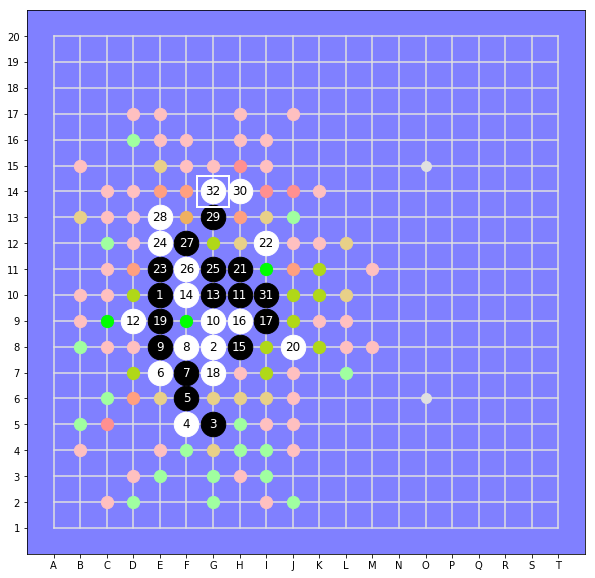

In [76]:
board.display('current')
q

In [77]:
sampler = policy.suggest_from_best_value(20, 2, .05)

In [78]:
sampler.choices

[(0.9158829538827955, (14, 7), 0.08411704611720447, -5.544767182963767),
 (0.8321261900031339, (7, 5), 0.08375676387966156, -5.630613281458636),
 (0.7487125229823903, (9, 3), 0.08341366702074357, -5.712708503396698),
 (0.6718447852155194, (6, 5), 0.07686773776687096, -7.347226813362624),
 (0.5977760601186834, (14, 3), 0.07406872509683592, -8.089084290430321),
 (0.5383634253591063, (10, 3), 0.05941263475957719, -12.498813682384196),
 (0.48493779581056795, (13, 3), 0.053425629548538384, -14.62314018683395),
 (0.4333832191545099, (11, 9), 0.051554576656058046, -15.33613213648323),
 (0.3842715290686285, (10, 9), 0.049111690085881385, -16.307010010163594),
 (0.33525356294916386, (7, 7), 0.04901796611946465, -16.34521415701994),
 (0.28765738387775364, (6, 4), 0.04759617907141024, -16.933902157055854),
 (0.2431042652478609, (13, 8), 0.04455311862989274, -18.255308797536202),
 (0.20196025328287104, (10, 10), 0.04114401196498987, -19.847383899579597),
 (0.16279698381535485, (9, 9), 0.0391632694

In [79]:
from QFunction import value_after
for move in sampler.choices:
    r,c=move[1]
    pos = gt.m2b(move[1], board.N)
    print(pos, value_after(board, pos, policy))


[8 6] -13.534995133890448
[ 6 13] -5.630613281458636
[ 4 11] -5.712708503396698
[ 6 14] -17.34238240035353
[4 6] -8.089084290430321
[ 4 10] -12.498813682384196
[4 7] -14.62314018683395
[10  9] -15.33613213648323
[10 10] -16.307010010163594
[ 8 13] -20.9858154053872
[ 5 14] -16.933902157055854
[9 7] -18.255308797536202
[11 10] -19.847383899579597
[10 11] -20.834165802091093
[11  8] -22.815488634830103
[11 11] -23.022684784309263
[ 7 12] -26.24854263168055
[9 8] -28.804534942764917
[3 9] -35.479999493019534
[6 9] -37.25844797711932


In [86]:
board.set(6,13)

In [87]:
policy.suggest_counter(style=2, topn=1)

Defending Win-in-2: (G, 12)

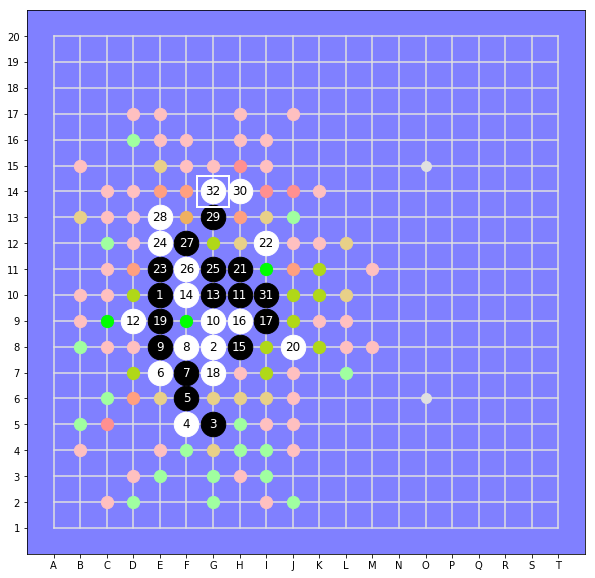

In [66]:
board.display('current')

In [81]:
policy.most_critical_pos()

In [82]:
board.current_color, policy.board.current_color

(1, 1)

In [83]:
import numpy as np
viewpoint = board.current_color
clean_scores = board.get_clean_scores()
o = np.argmax(clean_scores[1-viewpoint])
d = np.argmax(clean_scores[viewpoint]) 
xo, yo, vo = policy.pos_and_scores(o, 1-board.current_color)
xd, yd, vd = policy.pos_and_scores(d, board.current_color)
print(xo, yo, vo)
print(xd, yd, vd)
if vo > 7.0:
    print(Move(xo, yo, "Immediate win", IMMEDIATE_WIN))
elif vd > 7.0:
    if sorted(clean_scores[viewpoint].reshape(board.N*board.N))[-2] > 7.0:
        print(Move(0,0,"Two or more immediate threats. Giving up.", SURE_LOSS))


10 10 5.936837414520608
4 6 5.586777904672785


In [44]:
board.stones = policy.board.stones

In [90]:
from GomokuData import data_from_game

In [91]:
def get_train_data_function(heuristics, N):
   
    def _create_train_data(recording):
        strrep =  recording['game']
        print(strrep)
        stones = gt.string_to_stones(strrep)
        board = GomokuBoard(heuristics, N, disp_width=8, stones=stones)
        policy = HeuristicGomokuPolicy(board, 2)
        return data_from_game(board, policy, heuristics)

    return _create_train_data

In [98]:
create_training_data = get_train_data_function(heuristics, 20)

In [97]:
training_data = create_training_data(
    {'game': 'j20k20j19k19j18k18j17k17k16j16m16l15i15l14l13k13m15m13k15l12n14m11n10m12m14k12n12j12i12i11h10n13k10k11m18m17m9j10i9j11l11j13j9j14'})
training_data = create_training_data(
    {'game': 'r5q3n2o5n6n5o4p6p5n3q4p4q7p3o3o7n8l5o8m4k6m3m6l6l3j6m5j4l4j5j3k3i5q8j7m8r3o6p7n9l9m10o10m11m12l11h5i4o11o12h4n12k9k8g5o13p14n13q6s4p13k12j13n11n10j11k11n15n14m14l13l15k16p11'})
training_data = create_training_data(
    {'game': 'd20a20c19b19b18c18a17d17e16f16e15e14f14d16d15g15h14f17g13e17g17f18h12i11c15f19f15f20'})

j20k20j19k19j18k18j17k17k16j16m16l15i15l14l13k13m15m13k15l12n14m11n10m12m14k12n12j12i12i11h10n13k10k11m18m17m9j10i9j11l11j13j9j14
r5q3n2o5n6n5o4p6p5n3q4p4q7p3o3o7n8l5o8m4k6m3m6l6l3j6m5j4l4j5j3k3i5q8j7m8r3o6p7n9l9m10o10m11m12l11h5i4o11o12h4n12k9k8g5o13p14n13q6s4p13k12j13n11n10j11k11n15n14m14l13l15k16p11
d20a20c19b19b18c18a17d17e16f16e15e14f14d16d15g15h14f17g13e17g17f18h12i11c15f19f15f20


In [101]:
training_data = create_training_data(
    {'game': 
    'h13h15d15c16k12d17i12e18f19f17g16e17g17c17b17e16e15c18f15c15c14c19'
})

h13h15d15c16k12d17i12e18f19f17g16e17g17c17b17e16e15c18f15c15c14c19


In [1]:
stones=[(8, 13), (8, 15), (4, 15), (3, 16), (11, 12), (4, 17), (9, 12), (5, 18), (6, 19), (6, 17), (7, 16), (5, 17), (7, 17), (3, 17), (2, 17), (5, 16), (5, 15), (3, 18), (6, 15), (3, 15)]

In [12]:
stones = gt.string_to_stones('j20k20i20l20h20m20n18o20n20g20m17o19n16n19m15l18m16m14o17l14m19m18p16q15o16q16l16')

In [13]:
board = GomokuBoard(N=20, disp_width=10, heuristics=heuristics, stones=stones)

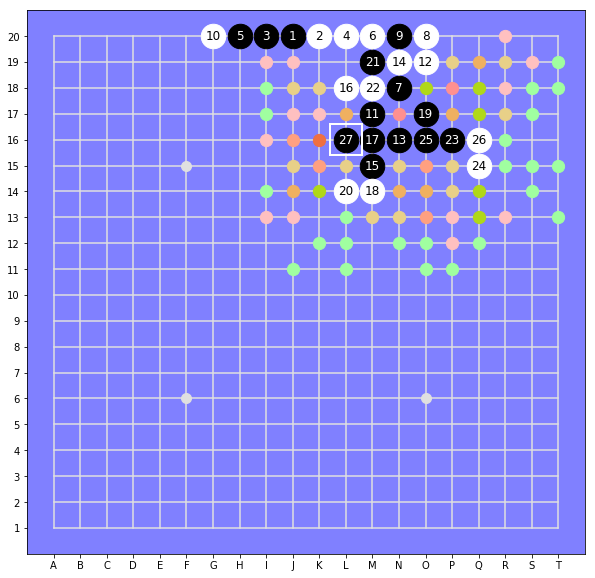

In [14]:
board.display('current')

In [12]:
q[0][0][0]

0.0